## Goal : Explainable AI - 4 tasks

In [1]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import transforms

## 關於載入、保存模型
- [官方中文文件](http://pytorch123.com/ThirdSection/SaveModel/)

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128,64,64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     # [64, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256,32,32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [521,16,16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512,8,8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     # [512, 4, 4]
            
        )

        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,11)
        )

    def forward(self,x):
        out = self.cnn(x)
        out = out.reshape(out.size()[0],-1)
        return self.fc(out)

In [10]:
model = torch.load('./3.model')
model

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## 使用cv2 將資料讀入numpy array 

In [12]:
def readfile(path, label):
    # label is a boolean value means wheather return the y value
    image_dir = sorted(os.listdir(path))
    #init data x and y
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        x[i, :, :] = cv2.resize(img, (128, 128))
        if label:
            y[i] = int(file.split('_')[0])
    
    if label:
        return x, y
    else:
        return x
    

In [13]:
print(os.listdir('./food-11/'))

['training', 'testing', 'validation']


In [14]:
work_dir = './food-11'
train_x , train_y = readfile(os.path.join(work_dir,'training'), True)
print('train data num : {}'.format(len(train_x)))
val_x , val_y = readfile(os.path.join(work_dir,'validation'), True)
print('val data num : {}'.format(len(val_x)))
test_x = readfile(os.path.join(work_dir,'testing'), False)
print('test data num : {}'.format(len(test_x)))

train data num : 9866
val data num : 3430
test data num : 3347


## Dataset 定義 與 data Transform 

In [15]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

class FoodDataSet(Dataset):
    '''
    ddddsad
    ssss
    '''
    def __init__(self, x, y=None, transforms=None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        X = self.x[index]
        if self.transforms is not None:
            X = self.transforms(X)
        
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X
    
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        
        return torch.stack(images), torch.tensor(labels)

## Task 1 - Sailency Map 
- 在component加上一些noise，看這些noise對結果是否有劇烈影響
- 反映到數學上，就是計算偏微分的絕對值
- 白色的點代表算出的偏微分數值越大
- 根據上述算出的結果，可以畫出Saliency Map

詳細說明：
通常的情況下，我們想要改變 model parameter 來 fit image 和 label。因此 loss 在計算 backward 時我們只在乎 loss 對 model parameter 的偏微分值。但數學上 image 本身也是 continuous tensor，我們可以計算 loss 對 image 的偏微分值。這個偏微分值代表「在 model parameter 和 label 都固定下，稍微改變 image 的某個 pixel value 會對 loss 產生什麼變化」。人們習慣把這個變化的劇烈程度解讀成該 pixel 的重要性 (每個 pixel 都有自己的偏微分值)。因此把同一張圖中，loss 對每個 pixel 的偏微分值畫出來，就可以看出該圖中哪些位置是 model 在判斷時的重要依據。

---
[python \*用法](https://blog.csdn.net/leviopku/article/details/82150990)

### 小插曲
- 分類用 cross entropy
- 預測用 mean square error

reason: 主要在於梯度下降的程度，若分類用mse會造成偏微分幾乎都為０，無法做梯度下降。

### [Normalize 與 Standardization 說明文章](https://aifreeblog.herokuapp.com/posts/54/data_science_203/) 

In [16]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model):
    model.eval()
    x = x.cuda()
    
    # 最關鍵的一行 code
    # 因為我們要計算 loss 對 input image 的微分，原本 input x 只是一個 tensor，預設不需要 gradient
    # 這邊我們明確的告知 pytorch 這個 input x 需要gradient，這樣我們執行 backward 後 x.grad 才會有微分的值
    x.requires_grad_()
    
    y_pred = model(x)
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.cuda())
    loss.backward()
    
    saliencies = x.grad.abs().detach().cpu()
    
    # saliencies: (batches, channels, height, weight)
    # 因為接下來我們要對每張圖片畫 saliency map，每張圖片的 gradient scale 很可能有巨大落差
    # 可能第一張圖片的 gradient 在 100 ~ 1000，但第二張圖片的 gradient 在 0.001 ~ 0.0001
    # 如果我們用同樣的色階去畫每一張 saliency 的話，第一張可能就全部都很亮，第二張就全部都很暗，
    # 如此就看不到有意義的結果，我們想看的是「單一張 saliency 內部的大小關係」，
    # 所以這邊我們要對每張 saliency 各自做 normalize。手法有很多種，這邊只採用最簡單的
    saliencies = torch.stack([normalize(item) for item in saliencies])
    
    return saliencies

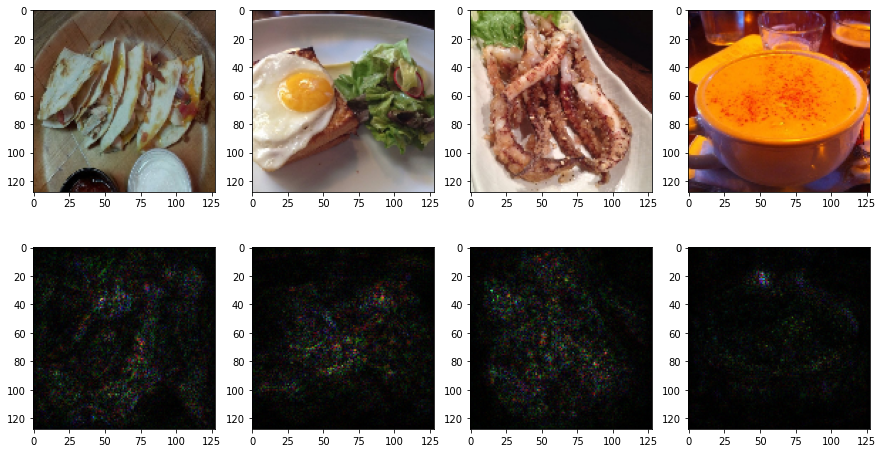

In [17]:
train_set = FoodDataSet(train_x, train_y, test_transform)
# 指定幾張visualize的圖片
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# 使用matplotlib 畫出
fig, axs = plt.subplots(2, len(img_indices), figsize=(15,8))
for row, target in enumerate([images, saliencies]):
    for column, img in enumerate(target):
        img = img.permute(1, 2, 0).numpy()
        # opencv讀入圖片是 BGR
        # 而Matplotlib是以 RGB來顯示
        # 所以以下兩個方法可以將 BGR 轉到 RGB 
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 注意这行。
        # img = img[:, :, ::-1]

        img = img[:, :, ::-1] #將 BGR 轉到 RGB
        axs[row][column].imshow(img)
        # 小知識：permute 是什麼，為什麼這邊要用?
        # 在 pytorch 的世界，image tensor 各 dimension 的意義通常為 (channels, height, width)
        # 但在 matplolib 的世界，想要把一個 tensor 畫出來，形狀必須為 (height, width, channels)
        # 因此 permute 是一個 pytorch 很方便的工具來做 dimension 間的轉換
        # 這邊 img.permute(1, 2, 0)，代表轉換後的 tensor，其
        # - 第 0 個 dimension 為原本 img 的第 1 個 dimension，也就是 height
        # - 第 1 個 dimension 為原本 img 的第 2 個 dimension，也就是 width
        # - 第 2 個 dimension 為原本 img 的第 0 個 dimension，也就是 channels
        
plt.show()
plt.close()
# 從第二張圖片的 saliency，我們可以發現 model 有認出蛋黃的位置
# 從第三、四張圖片的 saliency，雖然不知道 model 細部用食物的哪個位置判斷，但可以發現 model 找出了食物的大致輪廓

## Task 2 - Filter explaination 

這裡我們想要知道某一個 filter 到底認出了什麼。我們會做以下兩件事情：
- Filter activation: 挑幾張圖片出來，看看圖片中哪些位置會 activate 該 filter
- Filter visualization: 怎樣的 image 可以最大程度的 activate 該 filter

實作上比較困難的地方是，通常我們是直接把 image 丟進 model，一路 forward 到底。如：
```
loss = model(image)
loss.backward()
```
我們要怎麼得到中間某層 CNN 的 output? 當然我們可以直接修改 model definition，讓 forward 不只 return loss，也 return activation map。但這樣的寫法麻煩了，更改了 forward 的 output 可能會讓其他部分的 code 要跟著改動。因此 pytorch 提供了方便的 solution: **hook**，以下我們會再介紹。

In [18]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explaintaion(x, model, cnnid, filterid, iteration=100, lr=1):
    # x: 要用來觀察哪些位置可以 activate 被指定 filter 的圖片們
    # cnnid, filterid: 想要指定第幾層 cnn 中第幾個 filter
    model.eval()
    
    def hook(model, input, output):
        # 全域變數在沒有global時，只能讀取不能改寫
        global layer_activations 
        layer_activations = output

    hook_handle = model.cnn[cnnid].register_forward_hook(hook)
    # 上面這一行是在告訴 pytorch，當 forward 「過了」第 cnnid 層 cnn 後，要先呼叫 hook 這個我們定義的 function 後才可以繼續 forward 下一層 cnn
    # 因此上面的 hook function 中，我們就會把該層的 output，也就是 activation map 記錄下來，這樣 forward 完整個 model 後我們就不只有 loss
    # 也有某層 cnn 的 activation map
    # 注意：到這行為止，都還沒有發生任何 forward。我們只是先告訴 pytorch 等下真的要 forward 時該多做什麼事
    # 注意：hook_handle 可以先跳過不用懂，等下看到後面就有說明了    
    
    # Filter activation: 我們先觀察 x 經過被指定 filter 的 activation map
    model(x.cuda())
    # 這行才是正式執行 forward，因為我們只在意 activation map，所以這邊不需要把 loss 存起來
    filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
    
    # 根據 function argument 指定的 filterid 把特定 filter 的 activation map 取出來}
    # 因為目前這個 activation map 我們只是要把他畫出來，所以可以直接 detach from graph 並存成 cpu tensor
    
    # Filter visualization: 接著我們要找出可以最大程度 activate 該 filter 的圖片
    x = x.cuda()
    # 從一張 random noise 的圖片開始找 (也可以從一張 dataset image 開始找)
    x.requires_grad_()
    # 我們要對 input image 算偏微分
    optimizer = torch.optim.Adam([x], lr=lr)
    # 利用偏微分和 optimizer，逐步修改 input image 來讓 filter activation 越來越大
    for _iter in range(iteration):
        optimizer.zero_grad()
        model(x)
    
        objective = -layer_activations[:, filterid, :, :].sum()
        # 與上一個Task不同的是，我們並不想知道 image 的微量變化會怎樣影響 final loss
        # 我們想知道的是，image 的微量變化會怎樣影響 activation 的程度
        # 因此 objective 是 filter activation 的加總，然後加負號代表我們想要做 maximization
        
        objective.backward()# 計算 filter activation 對 input image 的偏微分
        optimizer.step()# 修改 input image 來最大化 filter activation
    
    # 完成圖片修改，只剩下要畫出來，因此可以直接 detach 並轉成 cpu tensor
    # [0]為 從四張圖片裡面選第零張圖片修改後的圖片
    # 這張圖片是讓該 [cnnid][filterid] 最大化的圖片
    filter_visualization = x.detach().cpu().squeeze()[0]
    
    hook_handle.remove()
    # 很重要：一旦對 model register hook，該 hook 就一直存在。如果之後繼續 register 更多 hook
    # 那 model 一次 forward 要做的事情就越來越多，甚至其行為模式會超出你預期 (因為你忘記哪邊有用不到的 hook 了)
    # 因此事情做完了之後，就把這個 hook 拿掉，下次想要再做事時再 register 就好了。
    
    return filter_activations, filter_visualization

In [19]:
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualization = filter_explaintaion(images, model, cnnid=6, filterid=5, iteration=100, lr=0.1)

In [20]:
print(filter_visualization.shape) # [3,128,128] 會是這個維度是因為這張圖是透過input的圖去修改，讓[cnnid][filterid] 最大化的圖片
print(filter_activations.shape)

torch.Size([3, 128, 128])
torch.Size([4, 64, 64])


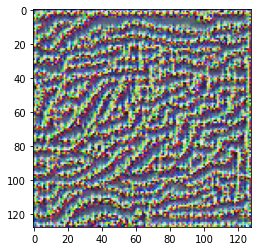

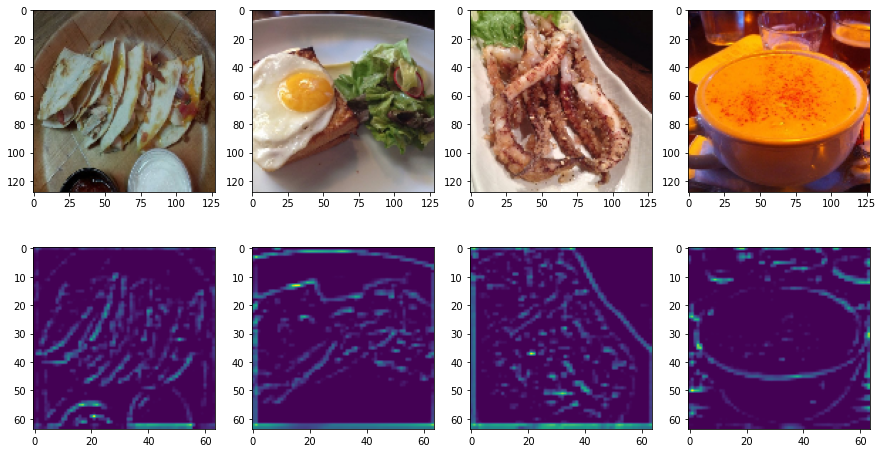

In [21]:
# 畫出 filter visualization
plt.imshow(normalize(filter_visualization.permute(1,2,0)))
plt.show()
plt.close()
# 根據圖片中的線條，可以猜測第 18 層 cnn 其第 0 個 filter 可能在認一些線條、甚至是 object boundary
# 因此給 filter 看一堆對比強烈的線條，他會覺得有好多 boundary 可以 activate

# 畫出 filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15,8))
for i, img in enumerate(images):
    img = img.permute(1, 2, 0).numpy()
    img = img[:, :, ::-1] #將 BGR 轉到 RGB
    axs[0][i].imshow(img)
for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))
plt.show()
plt.close()
# 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

## Lime
- [LimeImageExplainer doc](https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance)
- [explaination to image doc](https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask)
### 實作概念：
- 將圖片切分成多個segments
- 隨機刪除segments 丟入linear model
- 如果weight = 0 代表看到這個segment 與青蛙無關
- 如果weight > 0 代表看到這個segment 與青蛙有正向的影響
- 如果weight < 0 代表看到這個segment 會告訴我們這不是青蛙

### 補充：
- [zip用法](https://www.runoob.com/python3/python3-func-zip.html)


# 踩坑：
- 因為原本的模型在forward時候，從cnn 轉到 fn時，是用.view()去做reshape
- 而.view()的要求是data必須是contiguous的，而permute()動作會使得data non contiguous
- 所以在做完permute , transpose 等操作，再做view 就會報錯。
[參考資料](https://zhuanlan.zhihu.com/p/64551412)

In [22]:
from skimage.segmentation import slic
from lime import lime_image

/home/uscc/.pyenv/versions/3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  del sys.path[0]
100% |########################################################################|


KeyError: 'Label not in explanation'

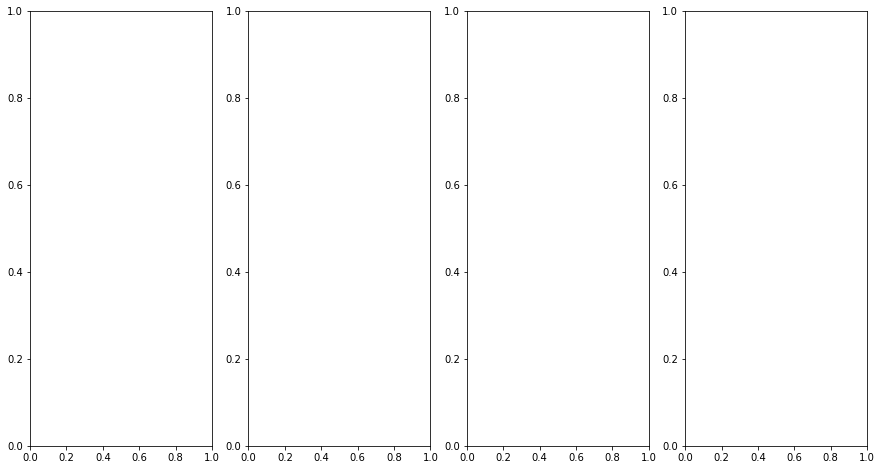

In [35]:
def predict(input):
    # input: numpy array, (batches, height, width, channels) 
    model.eval()
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)
    # 需要先將 input 轉成 pytorch tensor，且符合 pytorch 習慣的 dimension 定義
    # 也就是 (batches, channels, height, width)
    
    output = model(input.cuda())
    return output.detach().cpu().numpy()

def segmentation(input):
    # 利用 skimage 提供的 segmentation 將圖片分成 100 塊 
    return slic(input, n_segments=100, compactness=1, sigma=1)

img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(15,8))
np.random.seed(16) # 讓實驗 reproducible

#images.shape (batches, height, width, channels)
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):
    image = image[:,:,::-1]
    x = image.astype(np.double) # lime 這個套件要吃 numpy array
    
    
    # 基本上只要提供給 lime explainer 兩個關鍵的 function，事情就結束了
    # classifier_fn 定義圖片如何經過 model 得到 prediction
    # segmentation_fn 定義如何把圖片做 segmentation
    explainer = lime_image.LimeImageExplainer()
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
    
    lime_img, mask = explaination.get_image_and_mask(label=label.item(),
                                                    positive_only=False,
                                                    hide_rest=False,
                                                    num_features=11,
                                                    min_weight=0.05
                                                    )
    
    # 把 explainer 解釋的結果轉成圖片
    axs[idx].imshow(lime_img)

plt.show()
plt.close()

# 從以下前三章圖可以看到，model 有認出食物的位置，並以該位置為主要的判斷依據
# 唯一例外是第四張圖，看起來 model 似乎比較喜歡直接去認「碗」的形狀，來判斷該圖中屬於 soup 這個 class
# 至於碗中的內容物被標成紅色，代表「單看碗中」的東西反而有礙辨認。
# 當 model 只看碗中黃色的一坨圓形，而沒看到「碗」時，可能就會覺得是其他黃色圓形的食物。